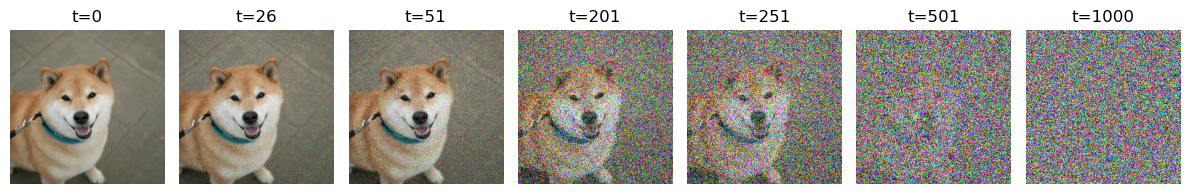

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# ──────────────────────────────────────────────────────────────
# 0. 이미지 불러오기 &  [-1, 1]  정규화
# ──────────────────────────────────────────────────────────────
img = cv2.imread("/Users/jeongseungmin/Desktop/Study/JSM/Generative/dog.jpeg")[..., ::-1]      # BGR→RGB
img = cv2.resize(img, (256, 256))                  # (선택) 작게
x0  = img.astype(np.float32) / 127.5 - 1.0         # [0,255] → [-1,1]


T          = 1000
beta_start = 1e-4
beta_end   = 0.02
beta = np.linspace(beta_start, beta_end, T, dtype=np.float32) # 1e-4 부터 0.02 사이의 1000개의 베타를 만들어준다.

alpha     = 1.0 - beta
alphabar  = np.cumprod(alpha)          # 한번에 모든 값들을 계산을 해서 조금 용이하게 접근할수 있도록 하는 방법
sqrt_alpha     = np.sqrt(alpha)
sqrt_one_minus = np.sqrt(1.0 - alpha)


def q_sample(xtm1, t):
    eps = np.random.randn(*xtm1.shape).astype(np.float32)
    xt  = sqrt_alpha[t]     * xtm1 + sqrt_one_minus[t] * eps
    return xt

xt = x0.copy()
snapshots = {0:xt}                  
for t in range(T):
    xt = q_sample(xt, t)
    if t in (25, 50, 200, 250, 500, 999):
        snapshots[t+1] = xt        

def to_img(x):       
    return np.clip((x + 1.0)/2.0, 0.0, 1.0)

plt.figure(figsize=(12,3))
for idx, (step, pic) in enumerate(sorted(snapshots.items())):
    plt.subplot(1, len(snapshots), idx+1)
    plt.imshow(to_img(pic))
    plt.axis('off')
    plt.title(f"t={step}")
plt.tight_layout()
plt.show()


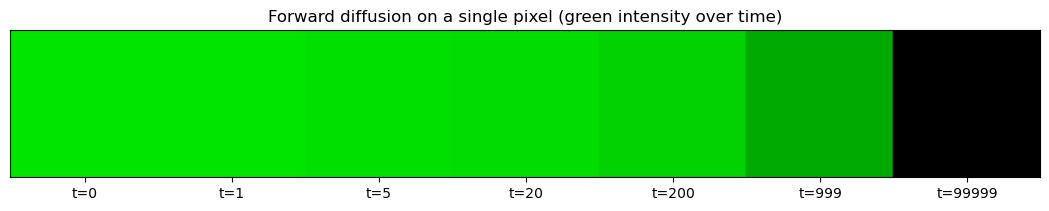

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Pick one green-channel pixel, normalized [-1,1]
g0 = 0.8

# noise schedule
T = 100000
beta = np.linspace(1e-4, 0.02, T, dtype=np.float32)
alpha = 1.0 - beta
sqrt_alpha = np.sqrt(alpha)
sqrt_one_minus = np.sqrt(1.0 - alpha)

# steps to visualize
show_steps = [0, 1, 5, 20, 200, 999, 99999]  # indices into simulation (999 shows after 1000 steps)
g_history = {}

g = g0
for t in range(T):
    if t in show_steps:
        g_history[t] = g
    eps = np.float32(np.random.randn())
    g = sqrt_alpha[t] * g + sqrt_one_minus[t] * eps

# include final value if not already captured
if T in show_steps:
    pass
else:
    g_history[T] = g

# prepare a horizontal strip of color blocks (RGB)
block_size = 60
n_blocks = len(show_steps)
strip = np.zeros((block_size, block_size * n_blocks, 3), dtype=np.float32)

for idx, step in enumerate(show_steps):
    g_val = g_history[step]
    g_vis = (g_val + 1.0) / 2.0  # map [-1,1] -> [0,1]
    g_vis = np.clip(g_vis, 0.0, 1.0)
    strip[:, idx*block_size:(idx+1)*block_size, 1] = g_vis  # green channel

# plot
plt.figure(figsize=(12,2))
plt.imshow(strip)
plt.xticks([(idx+0.5)*block_size for idx in range(n_blocks)],
           [f"t={step}" for step in show_steps])
plt.yticks([])
plt.title("Forward diffusion on a single pixel (green intensity over time)")
plt.tight_layout()

